In [60]:

import pandas as pd
import numpy as np
import sys
sys.path.append("../")
from src import soporte_clustering as s_clustering, soporte_eda_y_outliers as s_eda, soporte_encoding as s_encoding, soporte_tests_y_encoding as s_tests, soporte_scaling as s_estandarizacion

import seaborn as sns
import matplotlib.pyplot as plt 
import math

import pickle

In [61]:
df = pd.read_pickle("../datos/df_investigado")

In [62]:
df_ventas = df[["Order_Date","Ship_Date","Ship_Mode","Sub-Category","Product_Name","Sales","Quantity","Discount","Profit","Shipping_Cost","Order_Priority"]]

In [63]:
out = s_eda.GestionOutliersMultivariados(df_ventas)
df_lof = out.detectar_outliers_lof()

df_out, df_limpio = out.eliminar_outliers_abs(df_lof)

se han detectado 155 columnas con outliers absolutos


# Encoding 3

In [64]:
df_limpio.columns

Index(['Order_Date', 'Ship_Date', 'Ship_Mode', 'Sub-Category', 'Product_Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping_Cost',
       'Order_Priority'],
      dtype='object')

In [65]:
df_limpio.dtypes

Order_Date        datetime64[ns]
Ship_Date         datetime64[ns]
Ship_Mode                 object
Sub-Category              object
Product_Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping_Cost            float64
Order_Priority            object
dtype: object

In [66]:
def target_encoding_multiple(df, columns, target_column):
    for column in columns:
        encoder = TargetEncoder(cols=[column])
        df[f'{column}_target'] = encoder.fit_transform(df[column], df[target_column])
    return df

In [67]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder

# Copiar el DataFrame original
df_limpio2 = df_limpio.copy()

# Eliminar columnas irrelevantes
df_limpio2.drop(columns=["Order_Date", "Ship_Date", "Product_Name"], inplace=True)

# Seleccionar columnas categóricas
cols_cat = df_limpio2.select_dtypes(include="O").columns.tolist()

# Definir columnas para Ordinal Encoding
cols_ordinal = ["Ship_Mode", "Order_Priority"]

# Escalar valores de la columna "Discount"
df_limpio2["Discount"] = df_limpio2["Discount"] * 10

# Filtrar columnas para Target Encoding
cols_target = [col for col in cols_cat if col not in cols_ordinal]

# Aplicar Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
df_limpio2[cols_ordinal] = ordinal_encoder.fit_transform(df_limpio2[cols_ordinal])

# Aplicar Target Encoding
df_encoded2 = target_encoding_multiple(df_limpio2, cols_target, target_column="Sales")

# Mostrar el DataFrame resultante
df_encoded2.head()


,Ship_Mode,Sub-Category,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Sub-Category_target
0,1.0,Accessories,2309.650,7,0.0,762.1845,933.57,0.0,243.685934
2,0.0,Phones,5175.171,9,1.0,919.9710,915.49,3.0,507.712831
3,0.0,Phones,2892.510,5,1.0,-96.5400,910.16,3.0,507.712831
4,1.0,Copiers,2832.960,8,0.0,311.5200,903.04,0.0,665.638626
5,2.0,Phones,2862.675,5,1.0,763.2750,897.35,0.0,507.712831


In [68]:
df_encoded2.drop(columns = cols_target, inplace = True)

# Scaling 3


In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded2)

# Crear un nuevo DataFrame con los valores escalados
df_scaled2 = pd.DataFrame(scaled_data, columns=df_encoded2.columns)

<!-- # Scaling 3 -->

# Clustering 3

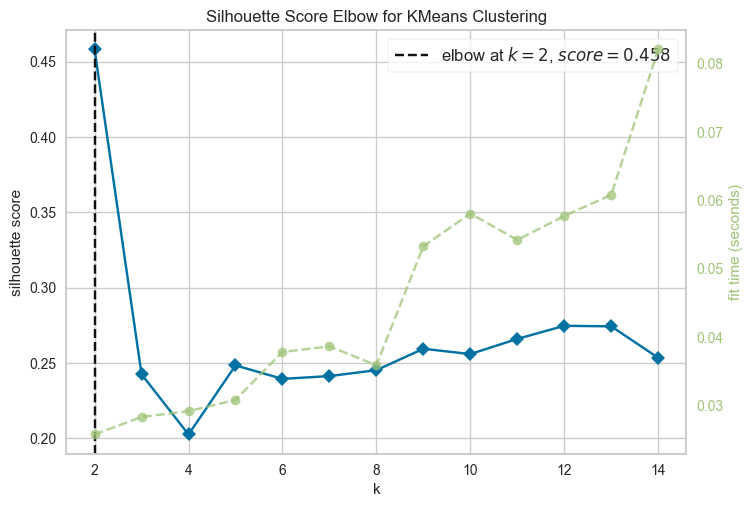

In [70]:
# instanciamos la clase de clustering
df_copia2 = df_scaled2.copy()
modelos = s_clustering.Clustering(df_copia2)

# sacamos el número de clusters óptimos para hacer el Kmeans 
modelos.sacar_clusters_kmeans()

In [71]:
from sklearn.cluster import KMeans
df_kmeans = df_copia2.copy()
kmeans = KMeans(n_clusters=2)
km_fit = kmeans.fit(df_kmeans)
labels = km_fit.labels_
df_kmeans["clusters_kmeans"] = labels.astype(str)


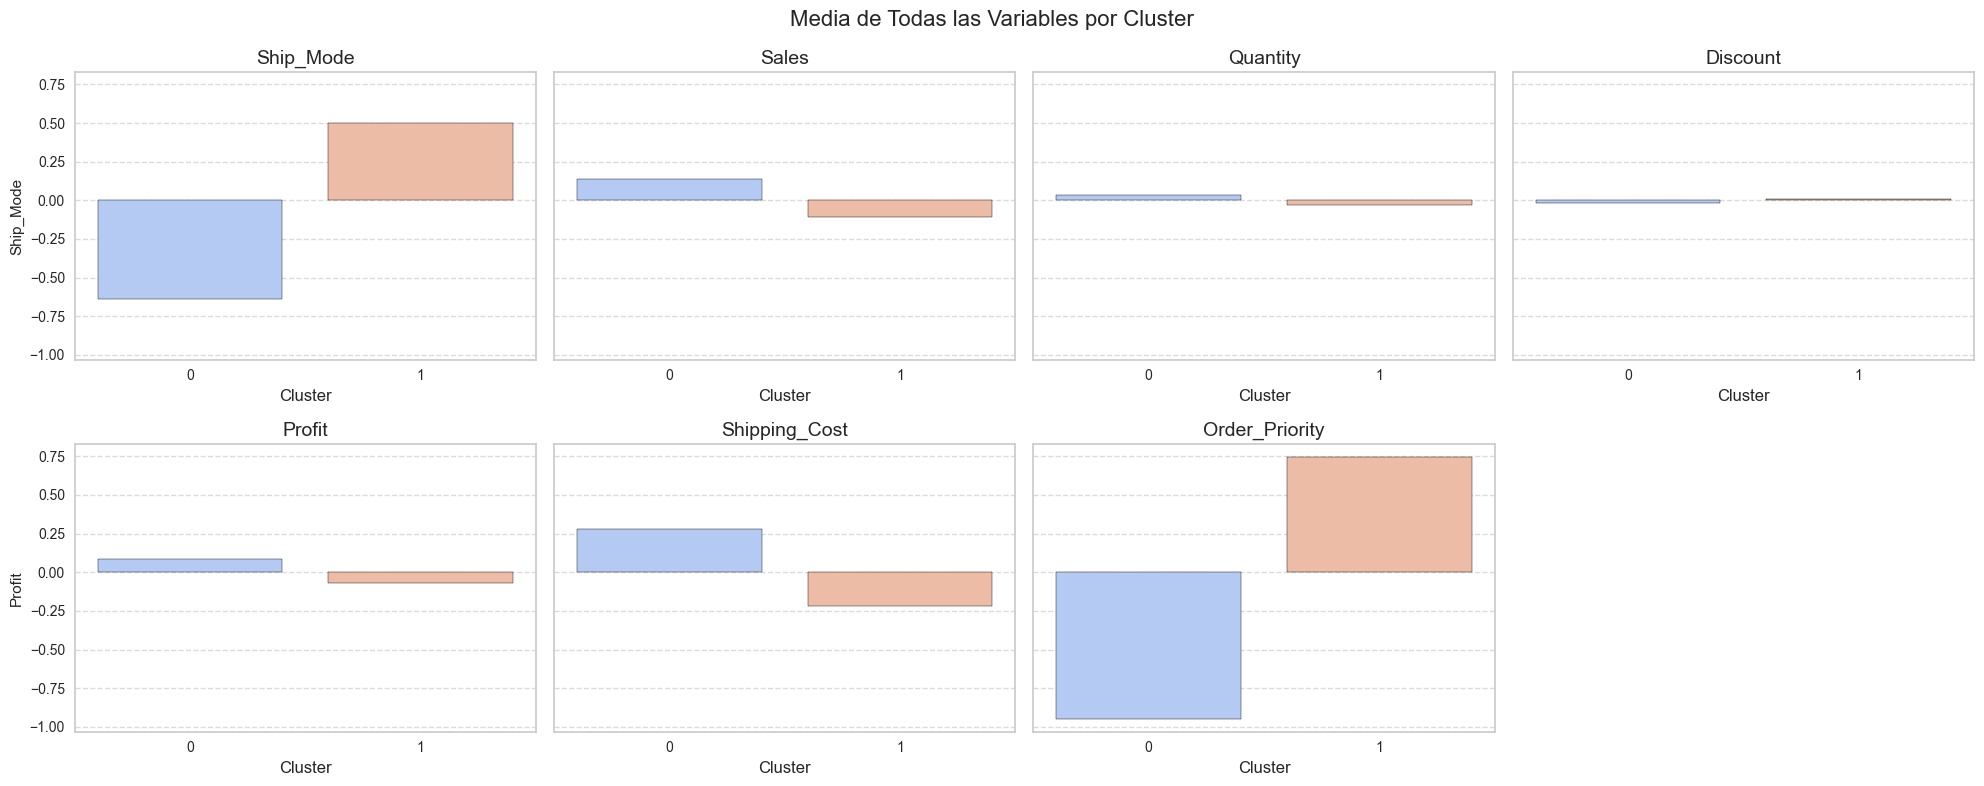

In [72]:

# Seleccionar todas las columnas excepto 'country' y agrupar por 'cluster'
columns_to_include = df_kmeans.drop(columns = "clusters_kmeans").columns  # Excluye 'country'

cluster_means = df_kmeans.groupby('clusters_kmeans')[columns_to_include].mean().reset_index()

# Crear el subplot dinámicamente
num_vars = len(columns_to_include)
fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(num_vars/ 2), figsize=(20,8), sharey=True)
axes = axes.flat
# Generar un barplot para cada variable en un subplot
for i, variable in enumerate(columns_to_include):
    sns.barplot(
        data=cluster_means,
        x='clusters_kmeans',
        y=variable,
        ax=axes[i],
        palette='coolwarm',
        edgecolor='black'
    )
    axes[i].set_title(f'{variable}', fontsize=14)
    axes[i].set_xlabel('Cluster', fontsize=12)

    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.delaxes(axes[-1])
# Título general del gráfico
fig.suptitle('Media de Todas las Variables por Cluster', fontsize=16)
plt.tight_layout()
plt.show()

In [73]:
def calcular_metricas(df, labels: np.ndarray):
        """
        Calcula métricas de evaluación del clustering.
        """
        if len(set(labels)) <= 1:
            raise ValueError("El clustering debe tener al menos 2 clusters para calcular las métricas.")

        silhouette = silhouette_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)

        unique, counts = np.unique(labels, return_counts=True)
        cardinalidad = dict(zip(unique, counts))

        return pd.DataFrame({
            "silhouette_score": silhouette,
            "davies_bouldin_index": davies_bouldin,
            "cardinalidad": cardinalidad
        }, index = [0])

In [74]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [75]:
calcular_metricas(df_kmeans, labels = df_kmeans["clusters_kmeans"])

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.235423,1.927024,NaN


In [76]:
df_dbscan = df_copia2.copy()
clus = s_clustering.Clustering(df_copia2)
clus.modelo_dbscan(df_dbscan)

eps: 0.5, min_samples: 3, silhouette: -0.16950424710511527
eps: 0.5, min_samples: 2, silhouette: -0.20119853141256794
eps: 0.5, min_samples: 1, silhouette: -0.22998288379625634
eps: 1.0, min_samples: 3, silhouette: 0.019667327488762716
eps: 1.0, min_samples: 2, silhouette: -0.06260320487236641
eps: 1.0, min_samples: 1, silhouette: -0.23192260742931264
eps: 1.5, min_samples: 3, silhouette: 0.3699054458764916
eps: 1.5, min_samples: 2, silhouette: 0.31722819488912657
eps: 1.5, min_samples: 1, silhouette: 0.09106818625763226


,Ship_Mode,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Sub-Category_target,clusters_dbscan
0,-1.161411,4.468843,1.563486,-0.672516,4.487372,16.033831,-1.964404,-0.004973,-1
1,-2.085620,10.670509,2.448288,-0.200726,5.452865,15.714326,0.814547,1.182577,-1
2,-2.085620,5.730290,0.678685,-0.200726,-0.767149,15.620135,0.814547,1.182577,-1
3,-1.161411,5.601409,2.005887,-0.672516,1.729763,15.494312,-1.964404,1.892901,-1
4,-0.237202,5.665720,0.678685,-0.200726,4.494045,15.393760,-1.964404,1.182577,-1
...,...,...,...,...,...,...,...,...,...
51130,-1.161411,-0.388895,0.678685,-0.672516,-0.148887,-0.463798,0.814547,-0.946565,3
51131,0.687007,-0.528826,-1.090918,3.101799,-0.183214,-0.463798,0.814547,1.491735,3
51132,-1.161411,-0.480183,-0.206116,-0.672516,-0.107701,-0.463798,-1.038087,-0.785282,3
51133,0.687007,-0.500700,-0.648517,-0.672516,-0.161737,-0.463975,0.814547,-0.763365,3


In [77]:
calcular_metricas(df_dbscan,labels = df_dbscan["clusters_dbscan"])

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.549052,1.060938,3
